# Capstone Phase 2 - ANN  
Exploration of Artificial Neural Networks

### Import some libraries we'll need

In [3]:
import joblib
import pandas as pd
import numpy as np
from sklearn import preprocessing
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Some Utility Stuff

In [4]:
def transform_data(df):
    no_labels = df.drop(['label', 'attack_cat'], axis=1)
    one_hot = pd.get_dummies(no_labels, columns=['proto', 'service', 'state'], prefix=['proto', 'service', 'state'])
    scaler = preprocessing.StandardScaler().fit(one_hot)
    standardized = scaler.transform(one_hot)
    std = pd.DataFrame(standardized, columns=one_hot.columns)

    labels = df['label'].copy()
    cats = df['attack_cat'].copy()
    
    return std, labels, cats

In [5]:
def gen_metrics(y_train, y_pred):
    conf_mat = confusion_matrix(y_train, y_pred)
    class_rep = classification_report(y_train, y_pred, zero_division=0)
    rep_dict = classification_report(y_train, y_pred, zero_division=0, output_dict=True)
    acc = accuracy_score(y_train, y_pred)
    return conf_mat, class_rep, rep_dict, acc

Print search results code from https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [6]:
def print_search_results(gs_results):
  print("Best: %f using %s" % (gs_results.best_score_, gs_results.best_params_))
  means = gs_results.cv_results_['mean_test_score']
  stds = gs_results.cv_results_['std_test_score']
  params = gs_results.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
  return

Cross-validation code adapted from https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/

In [ ]:
def kfold_cv(X, y, lr=0.001, batch=20, epoch=20):
  # Define per-fold score containers
  fold_accuracy = []
  fold_loss = []

  # Stratified K-Fold to avoid imbalanced class distribution for multiclassification
  kfold = model_selection.StratifiedKFold(n_splits=5)

  # Build and evaluate model for each fold
  f_num = 1
  for train, test in kfold.split(X, y):
    model = build_seq_model_3(input_shape=X.shape[1:], learning_rate=lr)
    print('Training fold', f_num)
    hist = model.fit(X.iloc[train], y[train], batch_size=batch, epochs=epoch, verbose=1)

    # Calculate and print accuracy and loss for fold
    scores = model.evaluate(X.iloc[test], y[test], verbose=0)
    print('Fold', f_num, ':',  model.metrics_names[0], '=', scores[0], ';', 
          model.metrics_names[1], '=', scores[1]*100, '%')
    fold_accuracy.append(scores[1] * 100)
    fold_loss.append(scores[0])

    f_num += 1

  # Print average accuracy and loss
  print('Score per fold')
  for i in range(0, len(fold_accuracy)):
    print('Fold', i+1, ': Loss=', fold_loss[i], '; Accuracy=', fold_accuracy[i], '%')
  print('Average scores for all folds:')
  print('Accuracy:', np.mean(fold_accuracy), '+-', np.std(fold_accuracy))
  print('Loss:', np.mean(fold_loss))
  return

### Load data and apply transformations

We need to upload the data file from our local drive.

In [7]:
from google.colab import files
uploaded = files.upload()

Saving UNSW_NB15 training and testing sets.zip to UNSW_NB15 training and testing sets.zip


Import the io library so we can load the file we uploaded.

In [8]:
import io

In [9]:
with ZipFile(io.BytesIO(uploaded['UNSW_NB15 training and testing sets.zip'])) as datasets_zip:
    # open each file and read in to a DataFrame
    with datasets_zip.open('UNSW_NB15_training-set.csv') as training_file:
        training_data = pd.read_csv(training_file, index_col='id')
    with datasets_zip.open('UNSW_NB15_testing-set.csv') as testing_file:
        testing_data = pd.read_csv(testing_file, index_col='id')

In [10]:
training_data_std, training_labels, training_cats = transform_data(training_data)
testing_data_std, testing_labels, testing_cats = transform_data(testing_data)

In [11]:
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(training_cats)
y_test = label_encoder.fit_transform(testing_cats)

In [12]:
class_names = list(label_encoder.classes_)

### Load feature subsets

First upload the file from our local drive

In [13]:
features_pkl = files.upload() # joblib.load('./data/feature_subsets.pkl')

Saving feature_subsets.pkl to feature_subsets.pkl


In [14]:
feature_subsets = joblib.load('feature_subsets.pkl')

In [15]:
train_std_ig = training_data_std[feature_subsets['ig']].copy()
test_std_ig = testing_data_std[feature_subsets['ig']].copy()

train_std_anova = training_data_std[feature_subsets['anova']].copy()
test_std_anova = testing_data_std[feature_subsets['anova']].copy()

train_std_vt = training_data_std[feature_subsets['vt']].copy()
test_std_vt = testing_data_std[feature_subsets['vt']].copy()

train_std_mad = training_data_std[feature_subsets['mad']].copy()
test_std_mad = testing_data_std[feature_subsets['mad']].copy()

train_std_corr = training_data_std[feature_subsets['corr']].copy()
test_std_corr = testing_data_std[feature_subsets['corr']].copy()

train_std_rfe = training_data_std[feature_subsets['rfe']].copy()
test_std_rfe = testing_data_std[feature_subsets['rfe']].copy()

## RandomizedSearchCV/GridSearchCV

Let's define a function to build models so we can wrap the model for use in Scikit-Learn functions, i.e. GridSearchCV.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
def build_seq_model(input_shape, num_layers=1, num_neurons=20, lr=0.001, activation='relu',
                    loss_func='sparse_categorical_crossentropy', metrics=['accuracy']):
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=input_shape))
  for layer in range(num_layers):
    model.add(keras.layers.Dense(num_neurons, activation=activation))
  model.add(keras.layers.Dense(10, activation='softmax')) # output layer for 10 class multiclassification
  optimizer = keras.optimizers.Adam(learning_rate=lr)
  model.compile(loss=loss_func, optimizer=optimizer, metrics=metrics)
  return model

In [ ]:
def build_seq_model_2(input_shape, lr=0.001, activation='relu', optimizer='Adam',
                    loss_func='sparse_categorical_crossentropy'):
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=input_shape))
  model.add(keras.layers.Dense(20, activation=activation))
  model.add(keras.layers.Dense(18, activation=activation))
  model.add(keras.layers.Dense(16, activation=activation))
  model.add(keras.layers.Dense(12, activation=activation))
  model.add(keras.layers.Dense(10, activation='softmax')) # output layer for 10 class multiclassification
  model.compile(loss=loss_func, optimizer=optimizer, metrics=['accuracy'])
  return model

### Tune Batch Size and Epochs

In [ ]:
params_bs_epoch = {'epochs':[20,30,50], 'batch_size':[10,20,40]}

In [ ]:
seq_model_bs_ep = keras.wrappers.scikit_learn.KerasClassifier(build_seq_model_2, input_shape=train_std_ig.shape[1:])

In [ ]:
grid_search_bs_ep = GridSearchCV(estimator=seq_model_bs_ep, param_grid=params_bs_epoch, cv=3, n_jobs=-1)

In [ ]:
gs_bs_ep_result = grid_search_bs_ep.fit(train_std_ig, y_train)

Epoch 1/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.8967 - accuracy: 0.6884
Epoch 2/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.6125 - accuracy: 0.7685
Epoch 3/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.5796 - accuracy: 0.7794
Epoch 4/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.5631 - accuracy: 0.7847
Epoch 5/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.5556 - accuracy: 0.7858
Epoch 6/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.5502 - accuracy: 0.7873
Epoch 7/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.5423 - accuracy: 0.7900
Epoch 8/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.5426 - accuracy: 0.7900
Epoch 9/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.5384 - accuracy: 0.7909
Epoch 10/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.535

In [ ]:
print_search_results(gs_bs_ep_result)

Best: 0.577851 using {'batch_size': 40, 'epochs': 50}
0.417940 (0.192916) with: {'batch_size': 10, 'epochs': 20}
0.372845 (0.190449) with: {'batch_size': 10, 'epochs': 30}
0.398869 (0.189594) with: {'batch_size': 10, 'epochs': 50}
0.472097 (0.108626) with: {'batch_size': 20, 'epochs': 20}
0.356842 (0.192834) with: {'batch_size': 20, 'epochs': 30}
0.381291 (0.194346) with: {'batch_size': 20, 'epochs': 50}
0.348857 (0.192692) with: {'batch_size': 40, 'epochs': 20}
0.502780 (0.254430) with: {'batch_size': 40, 'epochs': 30}
0.577851 (0.180061) with: {'batch_size': 40, 'epochs': 50}


### Tune Optimizer

In [ ]:
params_opt = {'optimizer':['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']}

In [ ]:
seq_model_opt = keras.wrappers.scikit_learn.KerasClassifier(build_seq_model_2, input_shape=train_std_ig.shape[1:],
                                                            batch_size=40, epochs=50)

In [ ]:
seq_model_opt.get_params()

{'batch_size': 40,
 'build_fn': <function __main__.build_seq_model_2>,
 'epochs': 50,
 'input_shape': (20,)}

In [ ]:
grid_search_opt = GridSearchCV(estimator=seq_model_opt, param_grid=params_opt, cv=3, n_jobs=-1)

In [ ]:
gs_opt_result = grid_search_opt.fit(train_std_ig, y_train)

Epoch 1/50
4384/4384 [==============================] - 6s 1ms/step - loss: 1.1027 - accuracy: 0.6156
Epoch 2/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.7330 - accuracy: 0.7234
Epoch 3/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6774 - accuracy: 0.7386
Epoch 4/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6503 - accuracy: 0.7622
Epoch 5/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6307 - accuracy: 0.7684
Epoch 6/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.6218 - accuracy: 0.7718
Epoch 7/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6090 - accuracy: 0.7731
Epoch 8/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.5978 - accuracy: 0.7767
Epoch 9/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.5875 - accuracy: 0.7789
Epoch 10/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.578

In [ ]:
print_search_results(gs_opt_result)

Best: 0.391625 using {'optimizer': 'Adamax'}
0.322800 (0.205774) with: {'optimizer': 'SGD'}
0.310800 (0.182299) with: {'optimizer': 'RMSprop'}
0.317142 (0.139361) with: {'optimizer': 'Adagrad'}
0.223382 (0.109293) with: {'optimizer': 'Adadelta'}
0.326746 (0.206875) with: {'optimizer': 'Adam'}
0.391625 (0.163013) with: {'optimizer': 'Adamax'}
0.332369 (0.202033) with: {'optimizer': 'Nadam'}


### Tune Learning Rate

In [ ]:
def build_seq_model_3(input_shape, learning_rate=0.001, activation='relu',
                    loss_func='sparse_categorical_crossentropy'):
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=input_shape))
  model.add(keras.layers.Dense(20, activation=activation))
  model.add(keras.layers.Dense(18, activation=activation))
  model.add(keras.layers.Dense(16, activation=activation))
  model.add(keras.layers.Dense(12, activation=activation))
  model.add(keras.layers.Dense(10, activation='softmax')) # output layer for 10 class multiclassification
  opt = keras.optimizers.Adamax(learning_rate=learning_rate)
  model.compile(loss=loss_func, optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
params_lr = {'learning_rate':[0.001, 0.002, 0.003, 0.01, 0.1, 0.2, 0.3]}

In [ ]:
seq_model_lr = keras.wrappers.scikit_learn.KerasClassifier(build_seq_model_3, input_shape=train_std_ig.shape[1:], 
                                                           batch_size=40, epochs=50)

In [ ]:
grid_search_lr = GridSearchCV(estimator=seq_model_lr, param_grid=params_lr, cv=3, n_jobs=-1)

In [ ]:
gs_lr_result = grid_search_lr.fit(train_std_ig, y_train)

Epoch 1/50
4384/4384 [==============================] - 6s 1ms/step - loss: 1.0054 - accuracy: 0.6341
Epoch 2/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.6681 - accuracy: 0.7486
Epoch 3/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.6306 - accuracy: 0.7646
Epoch 4/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.6116 - accuracy: 0.7705
Epoch 5/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.5985 - accuracy: 0.7740
Epoch 6/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.5901 - accuracy: 0.7735
Epoch 7/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.5769 - accuracy: 0.7782
Epoch 8/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.5777 - accuracy: 0.7779
Epoch 9/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.5746 - accuracy: 0.7777
Epoch 10/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.567

In [ ]:
print_search_results(gs_lr_result)

Best: 0.423386 using {'learning_rate': 0.002}
0.347158 (0.187192) with: {'learning_rate': 0.001}
0.423386 (0.184920) with: {'learning_rate': 0.002}
0.407389 (0.172616) with: {'learning_rate': 0.003}
0.380613 (0.186652) with: {'learning_rate': 0.01}
0.372486 (0.169755) with: {'learning_rate': 0.1}
0.292122 (0.095733) with: {'learning_rate': 0.2}
0.224802 (0.233214) with: {'learning_rate': 0.3}


## K-fold cross validation  
evaluate the model so far

In [ ]:
from sklearn import model_selection

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.preprocessing import StandardScaler

### First using the Info Gain feature subset.

In [ ]:
# Define per-fold score containers
fold_accuracy = []
fold_loss = []

# Stratified K-Fold to avoid imbalanced class distribution for multiclassification
kfold = model_selection.StratifiedKFold(n_splits=5)

# Build and evaluate model for each fold
f_num = 1
for train, test in kfold.split(train_std_ig, y_train):
  model = build_seq_model_3(input_shape=train_std_ig.shape[1:], learning_rate=0.002)
  print('Training fold', f_num)
  hist = model.fit(train_std_ig.iloc[train], y_train[train], batch_size=40, epochs=50, verbose=1)

  # Calculate and print accuracy and loss for fold
  scores = model.evaluate(train_std_ig.iloc[test], y_train[test], verbose=0)
  print('Fold', f_num, ':',  {model.metrics_names[0]}, '=', {scores[0]}, ';',
        {model.metrics_names[1]}, '=', {scores[1]*100}, '%')
  fold_accuracy.append(scores[1] * 100)
  fold_loss.append(scores[0])

  f_num += 1

# Print average accuracy and loss
print('Score per fold')
for i in range(0, len(fold_accuracy)):
  print('Fold', i+1, ': Loss=', fold_loss[i], '; Accuracy=', fold_accuracy[i], '%')
print('Average scores for all folds:')
print('Accuracy:', np.mean(fold_accuracy), '+-', np.std(fold_accuracy))
print('Loss:', np.mean(fold_loss))

Training fold 1
Epoch 1/50
3507/3507 [==============================] - 5s 1ms/step - loss: 1.0443 - accuracy: 0.6243
Epoch 2/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.6762 - accuracy: 0.7482
Epoch 3/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.6376 - accuracy: 0.7572
Epoch 4/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.6103 - accuracy: 0.7680
Epoch 5/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.5954 - accuracy: 0.7708
Epoch 6/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.5836 - accuracy: 0.7770
Epoch 7/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.5801 - accuracy: 0.7751
Epoch 8/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.5731 - accuracy: 0.7795
Epoch 9/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.5658 - accuracy: 0.7810
Epoch 10/50
3507/3507 [==============================] - 4s 1ms/st

Looks decent, let's train a new model with these parameters and save it.

In [ ]:
seq_mod3_ig = build_seq_model_3(input_shape=train_std_ig.shape[1:], learning_rate=0.002)
hist_seq_mod3_ig = seq_mod3_ig.fit(train_std_ig, y_train, batch_size=40, epochs=50)

Epoch 1/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.9778 - accuracy: 0.6459
Epoch 2/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6346 - accuracy: 0.7639
Epoch 3/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.5986 - accuracy: 0.7752
Epoch 4/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.5813 - accuracy: 0.7788
Epoch 5/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.5699 - accuracy: 0.7825
Epoch 6/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.5606 - accuracy: 0.7850
Epoch 7/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.5547 - accuracy: 0.7860
Epoch 8/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.5535 - accuracy: 0.7853
Epoch 9/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.5470 - accuracy: 0.7877
Epoch 10/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.548

In [ ]:
seq_mod3_ig.save('seq_mod3_ig.h5')
files.download('seq_mod3_ig.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's try some cross_val predictions with classification reports and confusion matrix.  
Let's use 10 folds to make sure the results are stable.

In [ ]:
seq_mod3_ig_wrapped = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_seq_model_3, 
                                                         input_shape=train_std_ig.shape[1:], 
                                                         learning_rate=0.002, epochs=50, 
                                                         batch_size=40, verbose=0)

In [ ]:
# Define stratified k-fold split
kfold = model_selection.StratifiedKFold(n_splits=10, shuffle=True)

In [ ]:
# evaluate using 10-fold cross validation
seq_mod3_ig_w_results = cross_val_score(seq_mod3_ig_wrapped, train_std_ig, y_train, cv=kfold)
print(seq_mod3_ig_w_results.mean())

0.7981304943561554


In [ ]:
seq_mod3_ig_w_results

array([0.79863131, 0.79947531, 0.79417133, 0.80044484, 0.79759324,
       0.79725105, 0.79542601, 0.79593933, 0.80061597, 0.80175656])

In [ ]:
y_pred_adamax_ig = cross_val_predict(seq_mod3_ig_wrapped, train_std_ig, y_train, cv=kfold)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

In [ ]:
conf_mat_adamax_ig, class_rep_adamax_ig, rep_dict_adamax_ig, acc_adamax_ig = gen_metrics(y_train, y_pred_adamax_ig)
print(class_rep_adamax_ig)

              precision    recall  f1-score   support

           0       0.62      0.07      0.13      2000
           1       0.60      0.00      0.00      1746
           2       0.38      0.05      0.09     12264
           3       0.60      0.92      0.72     33393
           4       0.63      0.65      0.64     18184
           5       1.00      0.98      0.99     40000
           6       0.92      0.89      0.91     56000
           7       0.77      0.70      0.73     10491
           8       0.50      0.28      0.36      1133
           9       0.50      0.01      0.02       130

    accuracy                           0.80    175341
   macro avg       0.65      0.45      0.46    175341
weighted avg       0.79      0.80      0.77    175341



In [ ]:
joblib.dump(seq_mod3_ig_wrapped, 'seq_mod3_ig_wrapped.pkl')
files.download('seq_mod3_ig_wrapped.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
joblib.dump(rep_dict_adamax_ig, 'rep_dict_ann_adamax_ig.pkl')
files.download('rep_dict_ann_adamax_ig.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OK, let's look at a confusion matrix.

In [ ]:
confmat_ig_df = pd.DataFrame(conf_mat_adamax_ig, index=class_names, columns=class_names)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

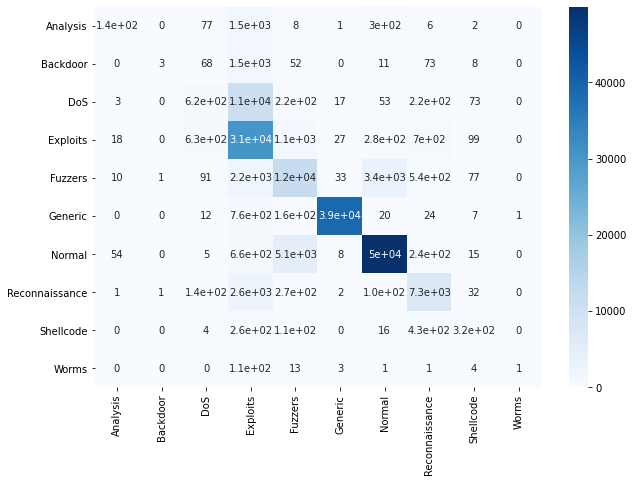

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(data=confmat_ig_df, annot=True, cmap='Blues')
plt.savefig('ann-adamax-ig-confmat.png', dpi=300, bbox_inches='tight')
files.download('ann-adamax-ig-confmat.png')
plt.show()

And let's see it normalized....

In [ ]:
#from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
confmat_ig_df_norm = pd.DataFrame(scaler.fit_transform(confmat_ig_df), index=class_names, columns=class_names)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

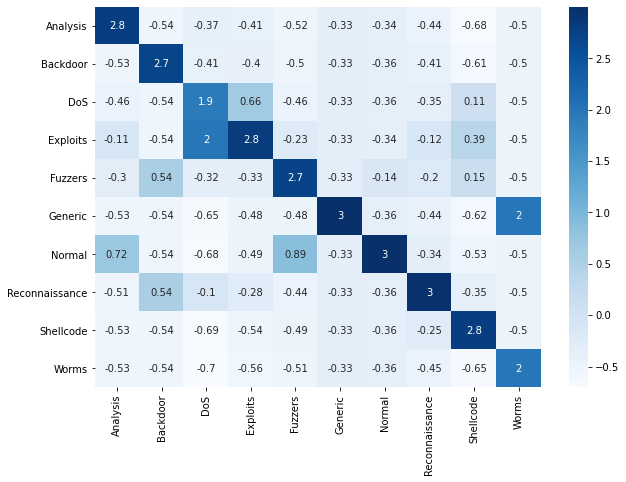

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(data=confmat_ig_df_norm, annot=True, cmap='Blues')
plt.savefig('ann-adamax-ig-confmat-stdscale.png', dpi=300, bbox_inches='tight')
files.download('ann-adamax-ig-confmat-stdscale.png')
plt.show()

### Next, using the ANOVA feature subset.

In [ ]:
kfold_cv(train_std_anova, y_train, lr=0.002, batch=40, epoch=50)

Training fold 1
Epoch 1/50
3507/3507 [==============================] - 4s 1ms/step - loss: 1.0610 - accuracy: 0.6071
Epoch 2/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.7406 - accuracy: 0.7200
Epoch 3/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.7089 - accuracy: 0.7270
Epoch 4/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.6942 - accuracy: 0.7315
Epoch 5/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.6808 - accuracy: 0.7350
Epoch 6/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.6715 - accuracy: 0.7388
Epoch 7/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.6714 - accuracy: 0.7389
Epoch 8/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.6659 - accuracy: 0.7396
Epoch 9/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.6630 - accuracy: 0.7427
Epoch 10/50
3507/3507 [==============================] - 4s 1ms/st

Let's train a new model with these parameters and save it.

In [ ]:
seq_mod3_anova = build_seq_model_3(input_shape=train_std_anova.shape[1:], learning_rate=0.002)
hist_seq_mod3_anova = seq_mod3_anova.fit(train_std_anova, y_train, batch_size=40, epochs=50)

Epoch 1/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.9402 - accuracy: 0.6676
Epoch 2/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.7072 - accuracy: 0.7318
Epoch 3/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6828 - accuracy: 0.7408
Epoch 4/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6638 - accuracy: 0.7459
Epoch 5/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6658 - accuracy: 0.7432
Epoch 6/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6498 - accuracy: 0.7489
Epoch 7/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6490 - accuracy: 0.7487
Epoch 8/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6436 - accuracy: 0.7495
Epoch 9/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6420 - accuracy: 0.7518
Epoch 10/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.636

In [ ]:
seq_mod3_anova.save('seq_mod3_anova.h5')
files.download('seq_mod3_anova.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's try some cross_val predictions with classification reports and confusion matrix.  
Let's use 10 folds to make sure the results are stable.

In [ ]:
seq_mod3_anova_wrapped = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_seq_model_3, 
                                                         input_shape=train_std_anova.shape[1:], 
                                                         learning_rate=0.002, epochs=50, 
                                                         batch_size=40, verbose=0)

In [ ]:
# Define stratified k-fold split
kfold = model_selection.StratifiedKFold(n_splits=10, shuffle=True)

In [ ]:
# evaluate using 10-fold cross validation
seq_mod3_anova_w_results = cross_val_score(seq_mod3_anova_wrapped, train_std_anova, y_train, cv=kfold)
print(seq_mod3_anova_w_results.mean())

0.7640996694564819


In [ ]:
seq_mod3_anova_w_results

array([0.76538354, 0.7675944 , 0.76069349, 0.76040834, 0.76622564,
       0.7635451 , 0.76519907, 0.76685297, 0.76343107, 0.76166308])

In [ ]:
y_pred_adamax_anova = cross_val_predict(seq_mod3_anova_wrapped, train_std_anova, y_train, cv=kfold)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

In [ ]:
conf_mat_adamax_anova, class_rep_adamax_anova, rep_dict_adamax_anova, acc_adamax_anova = gen_metrics(y_train, y_pred_adamax_anova)
print(class_rep_adamax_anova)

              precision    recall  f1-score   support

           0       0.69      0.07      0.12      2000
           1       0.00      0.00      0.00      1746
           2       0.35      0.05      0.08     12264
           3       0.56      0.85      0.67     33393
           4       0.61      0.59      0.60     18184
           5       0.99      0.97      0.98     40000
           6       0.92      0.88      0.90     56000
           7       0.48      0.55      0.51     10491
           8       0.00      0.00      0.00      1133
           9       0.36      0.03      0.06       130

    accuracy                           0.76    175341
   macro avg       0.50      0.40      0.39    175341
weighted avg       0.75      0.76      0.74    175341



In [ ]:
joblib.dump(seq_mod3_anova_wrapped, 'seq_mod3_anova_wrapped.pkl')
files.download('seq_mod3_anova_wrapped.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
joblib.dump(rep_dict_adamax_anova, 'rep_dict_ann_adamax_anova.pkl')
files.download('rep_dict_ann_adamax_anova.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OK, let's look at a confusion matrix.

In [ ]:
confmat_anova_df = pd.DataFrame(conf_mat_adamax_anova, index=class_names, columns=class_names)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

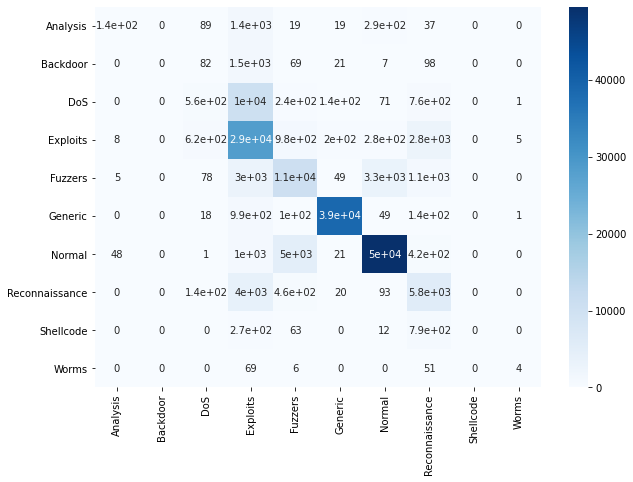

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(data=confmat_anova_df, annot=True, cmap='Blues')
plt.savefig('ann-adamax-anova-confmat.png', dpi=300, bbox_inches='tight')
files.download('ann-adamax-anova-confmat.png')
plt.show()

And let's see it normalized....

In [ ]:
scaler = StandardScaler()
confmat_anova_df_norm = pd.DataFrame(scaler.fit_transform(confmat_anova_df), index=class_names, columns=class_names)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

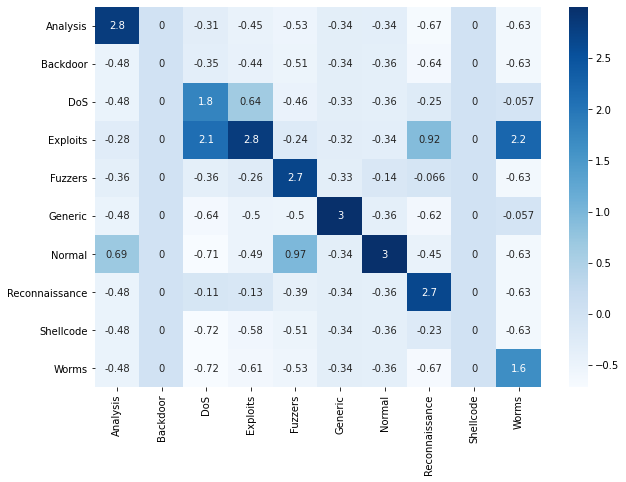

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(data=confmat_anova_df_norm, annot=True, cmap='Blues')
plt.savefig('ann-adamax-anova-confmat-stdscale.png', dpi=300, bbox_inches='tight')
files.download('ann-adamax-anova-confmat-stdscale.png')
plt.show()

### Variance Threshold feature subset.

In [ ]:
kfold_cv(train_std_vt, y_train, lr=0.002, batch=40, epoch=50)

Training fold 1
Epoch 1/50
3507/3507 [==============================] - 5s 1ms/step - loss: 1.1873 - accuracy: 0.5953
Epoch 2/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.8672 - accuracy: 0.6946
Epoch 3/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.8047 - accuracy: 0.7136
Epoch 4/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.7719 - accuracy: 0.7157
Epoch 5/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.7438 - accuracy: 0.7189
Epoch 6/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.7240 - accuracy: 0.7209
Epoch 7/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.7118 - accuracy: 0.7244
Epoch 8/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.7035 - accuracy: 0.7247
Epoch 9/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.6984 - accuracy: 0.7289
Epoch 10/50
3507/3507 [==============================] - 4s 1ms/st

Let's train a new model with these parameters and save it.

In [ ]:
seq_mod3_vt = build_seq_model_3(input_shape=train_std_vt.shape[1:], learning_rate=0.002)
hist_seq_mod3_vt = seq_mod3_vt.fit(train_std_vt, y_train, batch_size=40, epochs=50)

Epoch 1/50
4384/4384 [==============================] - 6s 1ms/step - loss: 1.1356 - accuracy: 0.6005
Epoch 2/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.7563 - accuracy: 0.7236
Epoch 3/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.7105 - accuracy: 0.7359
Epoch 4/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6911 - accuracy: 0.7424
Epoch 5/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6742 - accuracy: 0.7475
Epoch 6/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6707 - accuracy: 0.7478
Epoch 7/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6635 - accuracy: 0.7506
Epoch 8/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6612 - accuracy: 0.7487
Epoch 9/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.6600 - accuracy: 0.7506
Epoch 10/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.653

In [ ]:
seq_mod3_vt.save('seq_mod3_vt.h5')
files.download('seq_mod3_vt.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's try some cross_val predictions with classification reports and confusion matrix.  
Let's use 10 folds to make sure the results are stable.

In [ ]:
seq_mod3_vt_wrapped = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_seq_model_3, 
                                                         input_shape=train_std_vt.shape[1:], 
                                                         learning_rate=0.002, epochs=50, 
                                                         batch_size=40, verbose=0)

In [ ]:
# Define stratified k-fold split
kfold = model_selection.StratifiedKFold(n_splits=10, shuffle=True)

In [ ]:
# evaluate using 10-fold cross validation
seq_mod3_vt_w_results = cross_val_score(seq_mod3_vt_wrapped, train_std_vt, y_train, cv=kfold)
print(seq_mod3_vt_w_results.mean())

0.7634153068065643


In [ ]:
seq_mod3_vt_w_results

array([0.76082122, 0.7649709 , 0.76360214, 0.76120681, 0.76833582,
       0.76343107, 0.75784189, 0.76405841, 0.76691002, 0.7629748 ])

In [ ]:
y_pred_adamax_vt = cross_val_predict(seq_mod3_vt_wrapped, train_std_vt, y_train, cv=kfold)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

In [ ]:
conf_mat_adamax_vt, class_rep_adamax_vt, rep_dict_adamax_vt, acc_adamax_vt = gen_metrics(y_train, y_pred_adamax_vt)
print(class_rep_adamax_vt)

              precision    recall  f1-score   support

           0       0.69      0.02      0.03      2000
           1       0.00      0.00      0.00      1746
           2       0.47      0.01      0.02     12264
           3       0.56      0.84      0.67     33393
           4       0.49      0.71      0.58     18184
           5       1.00      0.98      0.99     40000
           6       0.94      0.83      0.88     56000
           7       0.74      0.67      0.70     10491
           8       0.36      0.06      0.10      1133
           9       1.00      0.01      0.02       130

    accuracy                           0.76    175341
   macro avg       0.62      0.41      0.40    175341
weighted avg       0.77      0.76      0.74    175341



In [ ]:
joblib.dump(seq_mod3_vt_wrapped, 'seq_mod3_vt_wrapped.pkl')
files.download('seq_mod3_vt_wrapped.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
joblib.dump(rep_dict_adamax_vt, 'rep_dict_ann_adamax_vt.pkl')
files.download('rep_dict_ann_adamax_vt.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OK, let's look at a confusion matrix.

In [ ]:
confmat_vt_df = pd.DataFrame(conf_mat_adamax_vt, index=class_names, columns=class_names)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

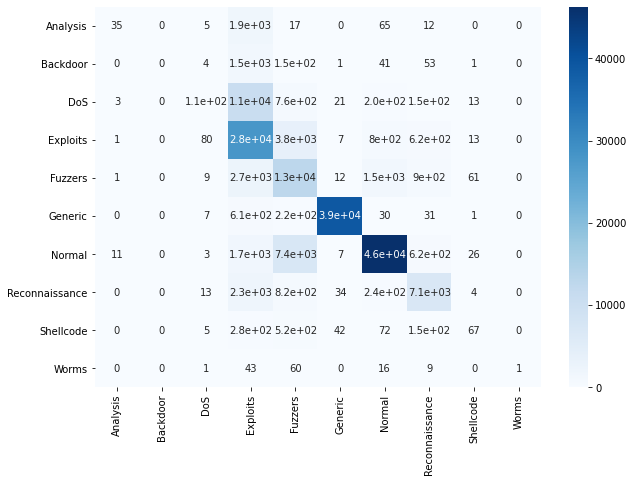

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(data=confmat_vt_df, annot=True, cmap='Blues')
plt.savefig('ann-adamax-vt-confmat.png', dpi=300, bbox_inches='tight')
files.download('ann-adamax-vt-confmat.png')
plt.show()

And let's see it normalized....

In [ ]:
scaler = StandardScaler()
confmat_vt_df_norm = pd.DataFrame(scaler.fit_transform(confmat_vt_df), index=class_names, columns=class_names)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

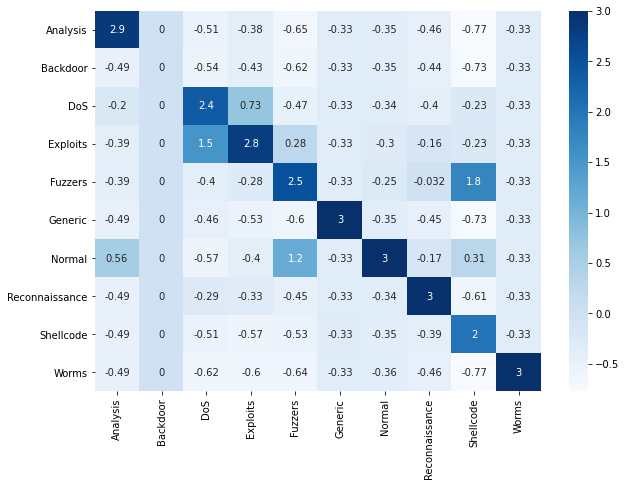

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(data=confmat_vt_df_norm, annot=True, cmap='Blues')
plt.savefig('ann-adamax-vt-confmat-stdscale.png', dpi=300, bbox_inches='tight')
files.download('ann-adamax-vt-confmat-stdscale.png')
plt.show()

### Median Absolute Deviation (MAD) feature subset.

In [ ]:
kfold_cv(train_std_mad, y_train, lr=0.002, batch=40, epoch=50)

Training fold 1
Epoch 1/50
3507/3507 [==============================] - 5s 1ms/step - loss: 1.0225 - accuracy: 0.6399
Epoch 2/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.7149 - accuracy: 0.7294
Epoch 3/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.6670 - accuracy: 0.7522
Epoch 4/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.6395 - accuracy: 0.7609
Epoch 5/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.6257 - accuracy: 0.7625
Epoch 6/50
3507/3507 [==============================] - 4s 1ms/step - loss: 0.6115 - accuracy: 0.7693
Epoch 7/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.6046 - accuracy: 0.7713
Epoch 8/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.5929 - accuracy: 0.7746
Epoch 9/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.5887 - accuracy: 0.7762
Epoch 10/50
3507/3507 [==============================] - 4s 1ms/st

Let's train a new model with these parameters and save it.

In [ ]:
seq_mod3_mad = build_seq_model_3(input_shape=train_std_mad.shape[1:], learning_rate=0.002)
hist_seq_mod3_mad = seq_mod3_mad.fit(train_std_mad, y_train, batch_size=40, epochs=50)

Epoch 1/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.9927 - accuracy: 0.6436
Epoch 2/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.6633 - accuracy: 0.7582
Epoch 3/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.6281 - accuracy: 0.7665
Epoch 4/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.6063 - accuracy: 0.7717
Epoch 5/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.5878 - accuracy: 0.7785
Epoch 6/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.5799 - accuracy: 0.7808
Epoch 7/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.5723 - accuracy: 0.7819
Epoch 8/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.5682 - accuracy: 0.7846
Epoch 9/50
4384/4384 [==============================] - 5s 1ms/step - loss: 0.5614 - accuracy: 0.7859
Epoch 10/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.559

In [ ]:
seq_mod3_mad.save('seq_mod3_mad.h5')
files.download('seq_mod3_mad.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's try some cross_val predictions with classification reports and confusion matrix.  
Let's use 10 folds to make sure the results are stable.

In [ ]:
seq_mod3_mad_wrapped = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_seq_model_3, 
                                                         input_shape=train_std_mad.shape[1:], 
                                                         learning_rate=0.002, epochs=50, 
                                                         batch_size=40, verbose=0)

In [ ]:
# Define stratified k-fold split
kfold = model_selection.StratifiedKFold(n_splits=10, shuffle=True)

In [ ]:
# evaluate using 10-fold cross validation
seq_mod3_mad_w_results = cross_val_score(seq_mod3_mad_wrapped, train_std_mad, y_train, cv=kfold)
print(seq_mod3_mad_w_results.mean())

0.797160941362381


In [ ]:
seq_mod3_mad_w_results

array([0.80074137, 0.79810655, 0.79753619, 0.80055892, 0.79211819,
       0.79337287, 0.79673779, 0.79753619, 0.79668075, 0.79822057])

In [ ]:
y_pred_adamax_mad = cross_val_predict(seq_mod3_mad_wrapped, train_std_mad, y_train, cv=kfold)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

In [ ]:
conf_mat_adamax_mad, class_rep_adamax_mad, rep_dict_adamax_mad, acc_adamax_mad = gen_metrics(y_train, y_pred_adamax_mad)
print(class_rep_adamax_mad)

              precision    recall  f1-score   support

           0       0.51      0.06      0.11      2000
           1       0.54      0.00      0.01      1746
           2       0.36      0.05      0.08     12264
           3       0.60      0.91      0.72     33393
           4       0.62      0.69      0.65     18184
           5       1.00      0.98      0.99     40000
           6       0.93      0.88      0.91     56000
           7       0.75      0.74      0.75     10491
           8       0.49      0.31      0.38      1133
           9       0.57      0.03      0.06       130

    accuracy                           0.80    175341
   macro avg       0.64      0.46      0.46    175341
weighted avg       0.79      0.80      0.77    175341



In [ ]:
joblib.dump(seq_mod3_mad_wrapped, 'seq_mod3_mad_wrapped.pkl')
files.download('seq_mod3_mad_wrapped.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
joblib.dump(rep_dict_adamax_mad, 'rep_dict_ann_adamax_mad.pkl')
files.download('rep_dict_ann_adamax_mad.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OK, let's look at a confusion matrix.

In [ ]:
confmat_mad_df = pd.DataFrame(conf_mat_adamax_mad, index=class_names, columns=class_names)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

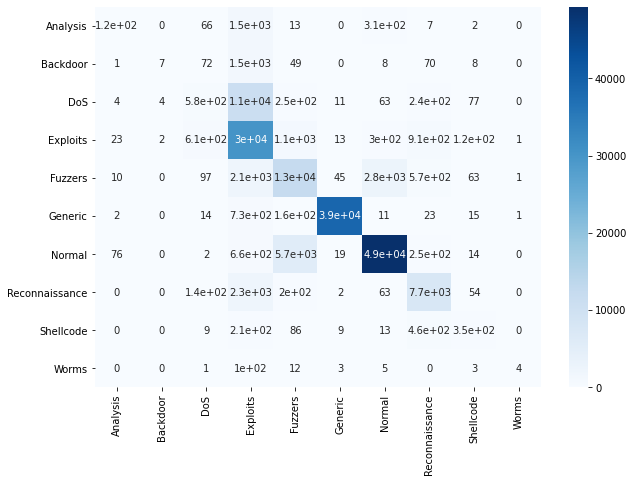

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(data=confmat_mad_df, annot=True, cmap='Blues')
plt.savefig('ann-adamax-mad-confmat.png', dpi=300, bbox_inches='tight')
files.download('ann-adamax-mad-confmat.png')
plt.show()

And let's see it normalized....

In [ ]:
scaler = StandardScaler()
confmat_mad_df_norm = pd.DataFrame(scaler.fit_transform(confmat_mad_df), index=class_names, columns=class_names)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

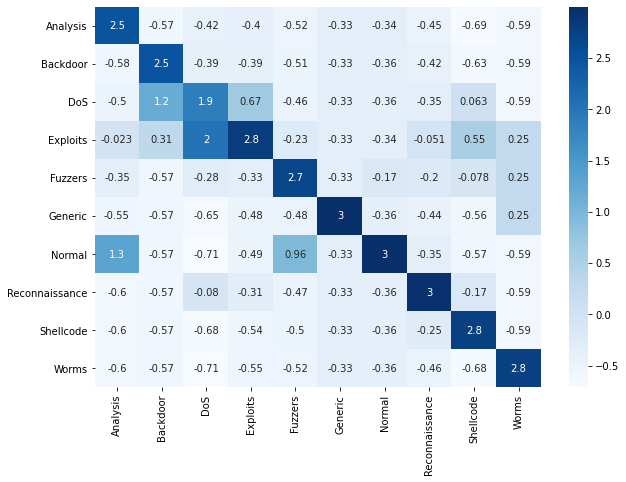

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(data=confmat_mad_df_norm, annot=True, cmap='Blues')
plt.savefig('ann-adamax-mad-confmat-stdscale.png', dpi=300, bbox_inches='tight')
files.download('ann-adamax-mad-confmat-stdscale.png')
plt.show()

### Finally, the best Correlation Coefficient feature subset.

In [ ]:
kfold_cv(train_std_corr, y_train, lr=0.002, batch=40, epoch=50)

Training fold 1
Epoch 1/50
3507/3507 [==============================] - 5s 1ms/step - loss: 1.1173 - accuracy: 0.6039
Epoch 2/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.7402 - accuracy: 0.7156
Epoch 3/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.6949 - accuracy: 0.7369
Epoch 4/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.6601 - accuracy: 0.7489
Epoch 5/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.6434 - accuracy: 0.7536
Epoch 6/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.6344 - accuracy: 0.7566
Epoch 7/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.6199 - accuracy: 0.7614
Epoch 8/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.6147 - accuracy: 0.7625
Epoch 9/50
3507/3507 [==============================] - 5s 1ms/step - loss: 0.6124 - accuracy: 0.7626
Epoch 10/50
3507/3507 [==============================] - 5s 1ms/st

Let's train a new model with these parameters and save it.

In [ ]:
seq_mod3_corr = build_seq_model_3(input_shape=train_std_corr.shape[1:], learning_rate=0.002)
hist_seq_mod3_corr = seq_mod3_corr.fit(train_std_corr, y_train, batch_size=40, epochs=50)

Epoch 1/50
4384/4384 [==============================] - 7s 1ms/step - loss: 1.0028 - accuracy: 0.6539
Epoch 2/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.7180 - accuracy: 0.7335
Epoch 3/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.6587 - accuracy: 0.7564
Epoch 4/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.6326 - accuracy: 0.7637
Epoch 5/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.6147 - accuracy: 0.7704
Epoch 6/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.6114 - accuracy: 0.7670
Epoch 7/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.6033 - accuracy: 0.7707
Epoch 8/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.5982 - accuracy: 0.7735
Epoch 9/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.5973 - accuracy: 0.7719
Epoch 10/50
4384/4384 [==============================] - 6s 1ms/step - loss: 0.592

In [ ]:
seq_mod3_corr.save('seq_mod3_corr.h5')
files.download('seq_mod3_corr.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's try some cross_val predictions with classification reports and confusion matrix.  
Let's use 10 folds to make sure the results are stable.

In [ ]:
seq_mod3_corr_wrapped = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_seq_model_3, 
                                                         input_shape=train_std_corr.shape[1:], 
                                                         learning_rate=0.002, epochs=50, 
                                                         batch_size=40, verbose=0)

In [ ]:
# Define stratified k-fold split
kfold = model_selection.StratifiedKFold(n_splits=10, shuffle=True)

In [ ]:
# evaluate using 10-fold cross validation
seq_mod3_corr_w_results = cross_val_score(seq_mod3_corr_wrapped, train_std_corr, y_train, cv=kfold)
print(seq_mod3_corr_w_results.mean())

0.7860854029655456


In [ ]:
seq_mod3_corr_w_results

array([0.78431708, 0.7871564 , 0.78333521, 0.78886735, 0.78299302,
       0.78841108, 0.78293604, 0.78863919, 0.78618681, 0.78801185])

In [ ]:
y_pred_adamax_corr = cross_val_predict(seq_mod3_corr_wrapped, train_std_corr, y_train, cv=kfold)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

In [ ]:
conf_mat_adamax_corr, class_rep_adamax_corr, rep_dict_adamax_corr, acc_adamax_corr = gen_metrics(y_train, y_pred_adamax_corr)
print(class_rep_adamax_corr)

              precision    recall  f1-score   support

           0       0.59      0.09      0.16      2000
           1       0.00      0.00      0.00      1746
           2       0.38      0.03      0.05     12264
           3       0.59      0.89      0.71     33393
           4       0.56      0.68      0.62     18184
           5       0.99      0.98      0.99     40000
           6       0.91      0.87      0.89     56000
           7       0.84      0.73      0.78     10491
           8       0.36      0.08      0.12      1133
           9       0.83      0.04      0.07       130

    accuracy                           0.79    175341
   macro avg       0.61      0.44      0.44    175341
weighted avg       0.77      0.79      0.76    175341



In [ ]:
joblib.dump(seq_mod3_corr_wrapped, 'seq_mod3_corr_wrapped.pkl')
files.download('seq_mod3_corr_wrapped.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
joblib.dump(rep_dict_adamax_corr, 'rep_dict_ann_adamax_corr.pkl')
files.download('rep_dict_ann_adamax_corr.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OK, let's look at a confusion matrix.

In [ ]:
confmat_corr_df = pd.DataFrame(conf_mat_adamax_corr, index=class_names, columns=class_names)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

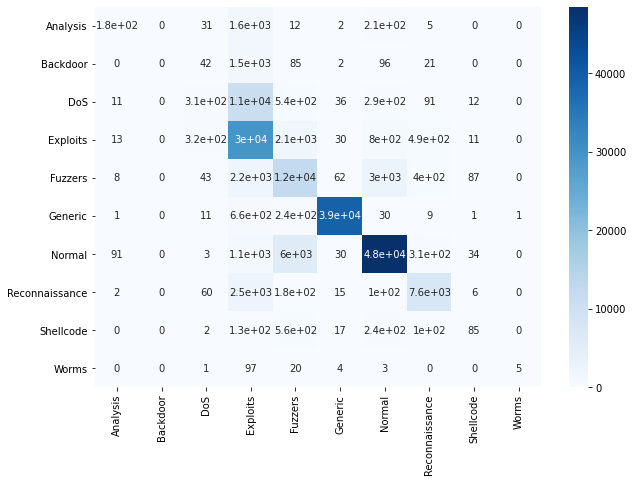

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(data=confmat_corr_df, annot=True, cmap='Blues')
plt.savefig('ann-adamax-corr-confmat.png', dpi=300, bbox_inches='tight')
files.download('ann-adamax-corr-confmat.png')
plt.show()

And let's see it normalized....

In [ ]:
scaler = StandardScaler()
confmat_corr_df_norm = pd.DataFrame(scaler.fit_transform(confmat_corr_df), index=class_names, columns=class_names)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

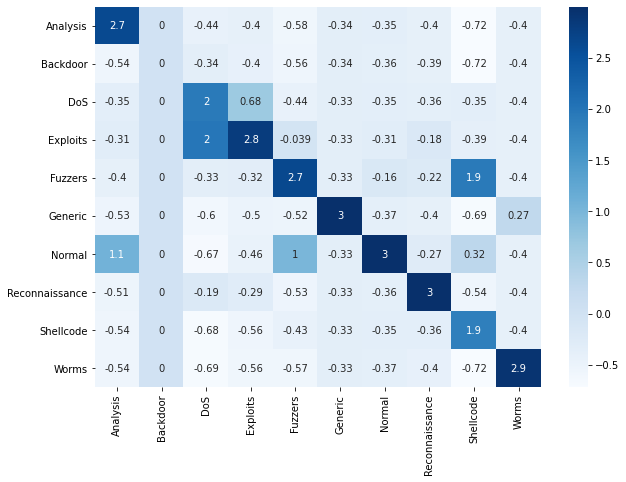

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(data=confmat_corr_df_norm, annot=True, cmap='Blues')
plt.savefig('ann-adamax-corr-confmat-stdscale.png', dpi=300, bbox_inches='tight')
files.download('ann-adamax-corr-confmat-stdscale.png')
plt.show()

## More hyperparamter tuning with Optuna

In [1]:
!pip install --quiet optuna

     |████████████████████████████████| 296kB 6.2MB/s 
     |████████████████████████████████| 163kB 21.0MB/s 
     |████████████████████████████████| 81kB 6.6MB/s 
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 112kB 17.5MB/s 
     |████████████████████████████████| 143kB 18.0MB/s 


In [2]:
import optuna
from sklearn.model_selection import train_test_split
from keras.constraints import maxnorm

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(train_std_ig, y_train, test_size=0.3, train_size=0.7, shuffle=True, stratify=y_train)

In [17]:
X_train.shape[0] == y_train.shape[0]

True

In [18]:
def objective(trial):    
    # define model with Dropout layers and use trial object to suggest hyperparameter values
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X_train.shape[1:]))
    model.add(keras.layers.Dense(20, activation=trial.suggest_categorical('activation', ['relu', 'tanh']),
                                 kernel_constraint=maxnorm(trial.suggest_int('weight_constraint', 1, 5))))
    model.add(keras.layers.Dropout(rate=trial.suggest_float('rate', 0.0, 0.9)))
    model.add(keras.layers.Dense(18, activation=trial.suggest_categorical('activation', ['relu', 'tanh']),
                                 kernel_constraint=maxnorm(trial.suggest_int('weight_constraint', 1, 5))))
    model.add(keras.layers.Dropout(rate=trial.suggest_float('rate', 0.0, 0.9)))
    model.add(keras.layers.Dense(16, activation=trial.suggest_categorical('activation', ['relu', 'tanh']),
                                 kernel_constraint=maxnorm(trial.suggest_int('weight_constraint', 1, 5))))
    model.add(keras.layers.Dropout(rate=trial.suggest_float('rate', 0.0, 0.9)))
    model.add(keras.layers.Dense(12, activation=trial.suggest_categorical('activation', ['relu', 'tanh']),
                                 kernel_constraint=maxnorm(trial.suggest_int('weight_constraint', 1, 5))))
    model.add(keras.layers.Dropout(rate=trial.suggest_float('rate', 0.0, 0.9)))
    model.add(keras.layers.Dense(10, activation='softmax')) # output layer for 10 class multiclassification

    # compile model and use trial object to suggest learning rate.
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=keras.optimizers.Adamax(learning_rate=lr), 
                  metrics=['accuracy'])
    
    model.fit(X_train, y_train,
              validation_data=(X_valid, y_valid),
#        validation_split=0.2, shuffle=True,
        batch_size=trial.suggest_int('batch_size', 10, 50), 
        epochs=trial.suggest_int('epochs', 20, 50),
        verbose=False)
    
    # evaluate returns [loss, accuracy], but we only want accuracy
    return model.evaluate(X_valid, y_valid, verbose=0)[1]

In [19]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.SuccessiveHalvingPruner())

[I 2021-04-15 18:32:50,835] A new study created in memory with name: no-name-62e2d6a8-366f-4344-bd98-cd82617d100b


In [20]:
study.optimize(objective, n_trials=20)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-04-15 18:36:32,163] Trial 0 finished with value: 0.7119175791740417 and parameters: {'activation': 'tanh', 'weight_constraint': 4, 'rate': 0.3563619023560203, 'lr': 0.0002326570327413404, 'batch_size': 30, 'epochs': 41}. Best is trial 0 with value: 0.7119175791740417.
[I 2021-04-15 18:40:15,717] Trial 1 finished with value: 0.7431325316429138 and parameters: {'activation': 'relu', 'weight_constraint': 4, 'rate': 0.025543037993655794, 'lr': 8.610737073819295e-05, 'batch_size': 20, 'epochs': 29}. Best is trial 1 with value: 0.7431325316429138.
[I 2021-04-15 18:43:42,093] Trial 2 finished with value: 0.7612493634223938 and parameters: {'activation': 'tanh', 'weight_constraint': 2, 'rate': 0.23279396262056226, 'lr': 0.009905114483678128, 'batch_size': 18, 'epochs': 24}. Best is trial 2 with value: 0.7612493634223938.
[I 2021-04-15 18:45:00,873] Trial 3 finished with value: 0.6543923616409302 and parameters: {'activation': 'relu', 'weight_constraint': 3, 'rate': 0.6439908856348059, 

Accuracy: 0.7965134978294373
Best hyperparameters: {'activation': 'tanh', 'weight_constraint': 2, 'rate': 0.014351949426392757, 'lr': 0.0018765350020431243, 'batch_size': 39, 'epochs': 37}


Similar to the network trained on the random forest optimum features, this one seems to be hovering right around 80% accuracy.  This is also consistent with the 10-fold cross-validation conducted above, using hyperparameter values found via grid-search, even with a different activation function.  
I'm not sure there's much point in conducting more trials, as the accuracy seems unlikely to get much higher.  As noted in the study of the optimum feature set, this is probably because several target classes are underrepresented in the data set.  
Interestingly, the model seems able to reach this level of accuracy with all of the feature subsets tested.

In [21]:
optuna.importance.get_param_importances(study)

OrderedDict([('rate', 0.7949209290025533),
             ('epochs', 0.10796404914749487),
             ('batch_size', 0.07886267420852855),
             ('weight_constraint', 0.008449218341942604),
             ('activation', 0.006749244323419178),
             ('lr', 0.003053884976061589)])

As with the other model, it seems the dropout rate is the most important parameter.

In [22]:
optuna.visualization.plot_param_importances(study)

In [23]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_intermediate_values(study)

In [25]:
optuna.visualization.plot_parallel_coordinate(study)

In [26]:
optuna.visualization.plot_contour(study)

In [27]:
optuna.visualization.plot_slice(study)

Would adding setting class weights help?

In [28]:
class_weights = dict(zip([0,1,2,3,4,5,6,7,8,9], (len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train)))))

In [29]:
def objective(trial):    
    # define model with Dropout layers and use trial object to suggest hyperparameter values
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X_train.shape[1:]))
    model.add(keras.layers.Dense(20, activation=trial.suggest_categorical('activation', ['relu', 'tanh']),
                                 kernel_constraint=maxnorm(trial.suggest_int('weight_constraint', 1, 5))))
    model.add(keras.layers.Dropout(rate=trial.suggest_float('rate', 0.0, 0.9)))
    model.add(keras.layers.Dense(18, activation=trial.suggest_categorical('activation', ['relu', 'tanh']),
                                 kernel_constraint=maxnorm(trial.suggest_int('weight_constraint', 1, 5))))
    model.add(keras.layers.Dropout(rate=trial.suggest_float('rate', 0.0, 0.9)))
    model.add(keras.layers.Dense(16, activation=trial.suggest_categorical('activation', ['relu', 'tanh']),
                                 kernel_constraint=maxnorm(trial.suggest_int('weight_constraint', 1, 5))))
    model.add(keras.layers.Dropout(rate=trial.suggest_float('rate', 0.0, 0.9)))
    model.add(keras.layers.Dense(12, activation=trial.suggest_categorical('activation', ['relu', 'tanh']),
                                 kernel_constraint=maxnorm(trial.suggest_int('weight_constraint', 1, 5))))
    model.add(keras.layers.Dropout(rate=trial.suggest_float('rate', 0.0, 0.9)))
    model.add(keras.layers.Dense(10, activation='softmax')) # output layer for 10 class multiclassification

    # compile model and use trial object to suggest learning rate.
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=keras.optimizers.Adamax(learning_rate=lr), 
                  metrics=['accuracy'])
    
    model.fit(X_train, y_train,
              validation_data=(X_valid, y_valid),
#        validation_split=0.2, shuffle=True,
        batch_size=trial.suggest_int('batch_size', 10, 50), 
        epochs=trial.suggest_int('epochs', 20, 50),
        class_weight=class_weights,
        verbose=False)
    
    # evaluate returns [loss, accuracy], but we only want accuracy
    return model.evaluate(X_valid, y_valid, verbose=0)[1]

In [30]:
study.optimize(objective, n_trials=20)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-04-15 20:21:53,234] Trial 20 finished with value: 0.7119365930557251 and parameters: {'activation': 'tanh', 'weight_constraint': 1, 'rate': 0.0037525053701510935, 'lr': 0.009265340331842674, 'batch_size': 45, 'epochs': 31}. Best is trial 13 with value: 0.7965134978294373.
[I 2021-04-15 20:24:47,513] Trial 21 finished with value: 0.6614831686019897 and parameters: {'activation': 'tanh', 'weight_constraint': 2, 'rate': 0.0782467246268013, 'lr': 0.0018202578900277818, 'batch_size': 36, 'epochs': 36}. Best is trial 13 with value: 0.7965134978294373.
[I 2021-04-15 20:28:08,822] Trial 22 finished with value: 0.6727943420410156 and parameters: {'activation': 'tanh', 'weight_constraint': 2, 'rate': 0.02998003902341287, 'lr': 0.0006157609666262063, 'batch_size': 36, 'epochs': 41}. Best is trial 13 with value: 0.7965134978294373.
[I 2021-04-15 20:31:20,603] Trial 23 finished with value: 0.4482824206352234 and parameters: {'activation': 'tanh', 'weight_constraint': 2, 'rate': 0.1523565156

Accuracy: 0.7965134978294373
Best hyperparameters: {'activation': 'tanh', 'weight_constraint': 2, 'rate': 0.014351949426392757, 'lr': 0.0018765350020431243, 'batch_size': 39, 'epochs': 37}


In [31]:
optuna.importance.get_param_importances(study)

OrderedDict([('rate', 0.6945137384619953),
             ('batch_size', 0.1580739477071347),
             ('epochs', 0.08342205221098543),
             ('lr', 0.02881981557165011),
             ('weight_constraint', 0.025675115995914984),
             ('activation', 0.009495330052319572)])

So, the model seems to perform much worse with the class weights specified.  Is there something wrong with the calculation of the weights?  This is the same formula used by Scikit-Learn classifiers.